### Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from scipy import stats as st

import numpy as np
import pandas as pd
import json
from tqdm.auto import tqdm
from typing import List, Union
import re
from bs4 import BeautifulSoup
import warnings

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import seaborn as sns

tqdm.pandas()
warnings.filterwarnings("ignore")

### Dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/ENSEMBLE_PROJECT/labeled_data.csv')

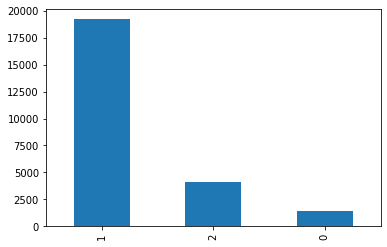

In [ ]:
dataset['class'].value_counts().plot(kind='bar');

In [ ]:
dataset = dataset.drop(columns=['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'], axis=1)
dataset.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Utils

In [ ]:
def ensemble_eval(model, device, criterion, test_dataloader):
    model = model.to(device)
    total = len(test_dataloader)

    y_true_test = []
    y_pred_test = []

    total_loss = 0
    batch_count = 0
    with torch.no_grad():
        for idx, batch in enumerate(test_dataloader):
            model.eval()

            input_ids = batch['input_ids'].to(device).long()
            label = batch['label'].to(device)

            out = model(input_ids)
            loss = criterion(out, label.squeeze(dim = -1))

            total_loss += loss.item()
            batch_count += 1

            predictions = F.softmax(out, dim=-1).argmax(dim=-1).flatten().detach().cpu().tolist()
            ground_truths = label.flatten().cpu().tolist()


            y_true_test.extend(ground_truths)
            y_pred_test.extend(predictions)

        test_acc = accuracy_score(y_true_test, y_pred_test)
        test_f1 = f1_score(y_true_test, y_pred_test, average='macro')
        test_loss = total_loss/batch_count

    return y_true_test, y_pred_test

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub(r'\[[^]]*\]', ' ', text)

def remove_special_characters(text):
    return re.sub(r"[^a-zA-Z\n\w0-9' ]", ' ', text)

def remove_extra_ws(text):
    return re.sub(r'[ ]{2,}', ' ', text)

def remove_new_line(text):
    return text.replace('\n', ' ')

def remove_side_integers(text):
    text = re.sub(r"\b\d+|\d+\b", "", text)
    return text

def remove_twitter_usernames(text):
    return re.sub(r'@\w+', '', text)

def remove_rt(text):
    return re.sub(r'RT @(\w+):', r'@\1:', text)

def denoise_text(text):
    functions = [
        remove_rt, remove_twitter_usernames,
        strip_html, remove_special_characters,
        remove_new_line, remove_new_line,
        remove_extra_ws, remove_side_integers
    ]
    for f in functions:
        text = f(text)
    text = text.lower().rstrip()
    return text

In [ ]:
def train(model, device, criterion, optimizer, train_dataloader, test_dataloader, epochs):
    model = model.to(device)
    total = len(train_dataloader) * epochs
    
    train_losses = []
    test_losses = []
    train_f1s = []
    test_f1s = []
    
    y_true_train = []
    y_pred_train = []

    with tqdm(total = total) as tt:
        for epoch in range(epochs):
            total_loss = 0
            batch_count = 0
            for idx, batch in enumerate(train_dataloader):
                model.train()

                input_ids = batch['input_ids'].to(device).long()
                label = batch['label'].to(device)

                optimizer.zero_grad()
                out = model(input_ids)
                loss = criterion(out, label.squeeze(dim = -1))
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                batch_count += 1

                predictions = F.softmax(out, dim=-1).argmax(dim=-1).flatten().detach().cpu().tolist()
                ground_truths = label.flatten().cpu().tolist()


                y_true_train.extend(ground_truths)
                y_pred_train.extend(predictions)

                tt.update()
            
            train_acc = accuracy_score(y_true_train, y_pred_train)
            train_f1 = f1_score(y_true_train, y_pred_train, average='macro')

            test_acc, test_f1, test_loss = evaluate(
                model=model, 
                device=device, 
                criterion=criterion, 
                test_dataloader=test_dataloader
            )

            print(30 * '*' + f'{epoch+1}/{epochs}' + 30 * '*')
            print(f'  - Train Loss: {total_loss/batch_count}')
            train_losses.append(total_loss/batch_count)
            print(f'  - Train Accuracy: {train_acc}')
            print(f'  - Train F1: {train_f1}')
            train_f1s.append(train_f1)
            print(f'  - Test Loss: {test_loss}')
            test_losses.append(test_loss) 
            print(f'  - Test Accuracy: {test_acc}')
            print(f'  - Test F1: {test_f1}')
            test_f1s.append(test_f1)
    
    return train_losses, test_losses, train_f1s, test_f1s, model


def evaluate(model, device, criterion, test_dataloader):
    model = model.to(device)
    total = len(test_dataloader)

    y_true_test = []
    y_pred_test = []

    with tqdm(total = total) as tt:
        total_loss = 0
        batch_count = 0
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                model.eval()

                input_ids = batch['input_ids'].to(device).long()
                label = batch['label'].to(device)

                out = model(input_ids)
                loss = criterion(out, label.squeeze(dim = -1))

                total_loss += loss.item()
                batch_count += 1

                predictions = F.softmax(out, dim=-1).argmax(dim=-1).flatten().detach().cpu().tolist()
                ground_truths = label.flatten().cpu().tolist()


                y_true_test.extend(ground_truths)
                y_pred_test.extend(predictions)

                tt.update()
            
            test_acc = accuracy_score(y_true_test, y_pred_test)
            test_f1 = f1_score(y_true_test, y_pred_test, average='macro')
            test_loss = total_loss/batch_count

    return test_acc, test_f1, test_loss

### Proprocessing

In [ ]:
dataset['tweet'] = dataset['tweet'].progress_apply(denoise_text)

  0%|          | 0/24783 [00:00<?, ?it/s]

In [ ]:
dataset.head()

,class,tweet
0,2,as a woman you shouldn't complain about clean...
1,1,boy dats cold tyga dwn bad for cuffin dat hoe...
2,1,rt dawg you ever fuck a bitch and she start t...
3,1,she look like a tranny
4,1,the shit you hear about me might be true or i...


### Train-Test Split

In [ ]:
train_df, test_df = train_test_split(
    dataset, 
    train_size=0.8,
    test_size=0.2,
    stratify=dataset['class'],
    random_state=137
)

train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [ ]:
print(len(train_df), len(test_df))

19826 4957


### Tokenizer

In [ ]:
class TokenizerBase(object):
    def __init__(
            self,
            unk_token: str = "[UNK]", 
            start_token: str = "[START]",
            end_token: str = "[END]",
            pad_token: str = "[PAD]",
            mask_token: str = "[MASK]"
    ) -> None:
        
        self.unk_token = unk_token
        self.start_token = start_token
        self.end_token = end_token
        self.pad_token = pad_token
        self.mask_token = mask_token

        self.start_token_id = 1
        self.end_token_id = 2
        self.pad_token_id = 3
        self.unk_token_id = 0
        self.mask_token_id = 4

        self.special_tokens = {
            self.unk_token: self.unk_token_id,
            self.start_token: self.start_token_id,
            self.end_token: self.end_token_id,
            self.pad_token: self.pad_token_id,
            self.mask_token: self.mask_token_id
        }

    def get_special_tokens(self) -> List[str]:
        return list(self.special_tokens.keys())

    def get_special_token_ids(self) -> List[int]:
        return list(self.special_tokens.values())

class SpaceTokenizer(TokenizerBase):
    def __init__(
            self,
            start_token: str = "[START]",
            end_token: str = "[END]",
            pad_token: str = "[PAD]",
            unk_token: str = "[UNK]",
            mask_token: str = "[MASK]",
            cased: bool = True
    ) -> None:
        super(SpaceTokenizer, self).__init__(
            start_token = start_token,
            end_token = end_token,
            pad_token = pad_token,
            unk_token = unk_token,
            mask_token = mask_token
        )

        self.w2i = {
            self.start_token: self.start_token_id,
            self.end_token: self.end_token_id,
            self.pad_token: self.pad_token_id,
            self.unk_token: self.unk_token_id,
            self.mask_token: self.mask_token_id
        }

        self.cased = cased


    def fit(self, data: Union[str, pd.DataFrame]) -> None:
        id_count = 5
        
        if type(data) == str:
            with open(data, "r") as f:
                data = f.read()

            data = data.split()
            for word in data:
                if self.cased == False:
                    word = word.lower()
                if word not in self.w2i.keys():
                    self.w2i[word] = id_count
                    id_count +=1

        else:
            if type(data) == str and data.split(".")[-1] == ".csv":
                data = pd.read_csv(data)
            elif type(data) == pd.DataFrame:
                pass
            else:
                raise NotImplementedError(f"type {type(data)} is not currently supported for tokenization.")
            
            for sentence in data.iloc[:,0]:
                splitted = sentence.split()
                for word in splitted:
                    if self.cased == False:
                        word = word.lower()
                    if word not in self.w2i.keys():
                        self.w2i[word] = id_count
                        id_count +=1

        self.i2w = {v: k for k, v in self.w2i.items()}
        print(f"Vocab size: {len(self.w2i)}")
        self.vocab_size = len(self.w2i)

    def encode(self, sentence: str, max_len: int = 512) -> List[int]:
        if self.cased == False:
            sentence = sentence.lower()
        s_len = 2
        encoded = []
        encoded.append(self.start_token_id)
        splitted = sentence.split()
        for word in splitted:
            s_len+=1
            if word not in self.w2i:
                encoded.append(self.unk_token_id)
            else:
                encoded.append(self.w2i[word])
            if max_len != None and s_len == max_len-1:
                break
        encoded.append(self.end_token_id)
        if max_len != None:
            for _ in range(s_len, max_len):
                encoded.append(self.pad_token_id)
        return encoded

    def decode(self, token_ids: List[int], remove_special_tokens: bool = False) -> str:
        decoded = []
        for token_id in token_ids:
            decoded.append(self.i2w[token_id])
        if remove_special_tokens:
            decoded = self.remove_special_tokens(decoded)
        return decoded
    
    def remove_special_tokens(self, tokens: Union[str, List[str]], from_str: bool = False) -> List[str]:
        if not from_str:
            for token in self.get_special_tokens():
                tokens = list(filter((token).__ne__, tokens))
                
        else:
            tokens = tokens.split()
            for token in self.get_special_tokens():
                tokens = list(filter((token).__ne__, tokens))
            tokens = ' '.join(tokens)
        return tokens

    def save(self, directory: str) -> None:
        if directory[-1] != "/":
            directory += "/"
        with open(directory + "vocab.json", "w") as vocab_f:
            json.dump(self.w2i, vocab_f)

        params = dict(
            unk_token = self.unk_token,
            start_token = self.start_token,
            end_token = self.end_token,
            pad_token = self.pad_token,
            mask_token = self.mask_token,
            cased = self.cased,
            unk_token_id = self.unk_token_id,
            start_token_id = self.start_token_id,
            end_token_id = self.end_token_id,
            pad_token_id = self.pad_token_id,
            mask_token_id = self.mask_token_id
        )
        with open(directory + "params.json", "w") as params_f:
            json.dump(params, params_f)

    def load(self, directory: str) -> None:
        if directory[-1] != "/":
            directory += "/"

        with open(directory + "vocab.json", "r") as vocab_f:
            self.w2i = json.load(vocab_f)

        self.i2w = {v: k for k, v in self.w2i.items()}

        with open(directory + "params.json", "r") as params_f:
            params = json.load(params_f)
        self.cased = params["cased"]
        self.vocab_size = len(self.w2i)

### Dataset Class

In [ ]:
class HateSpeechDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_len):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset.loc[idx, 'tweet']
        label = self.dataset.loc[idx, 'class']

        input_ids = self.tokenizer.encode(text, self.max_len)

        return {
            'input_ids': torch.Tensor(input_ids),
            'label': torch.tensor(label)
        }

### Tokenizer Fit

In [ ]:
tokenizer = SpaceTokenizer(cased=False)
tokenizer.fit(pd.DataFrame(train_df['tweet']))

Vocab size: 20566


34 6.679144030999107 2 15.128820740441844


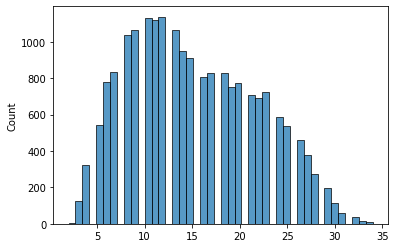

In [ ]:
sequence_lengths = [len(tokenizer.encode(a, max_len=None)) for a in train_df['tweet']]
print(max(sequence_lengths), np.std(sequence_lengths), min(sequence_lengths), np.mean(sequence_lengths))
sns.histplot(sequence_lengths);

### Dataloaders

In [ ]:
train_data_sampler = HateSpeechDataset(train_df, tokenizer, 50)
test_data_sampler = HateSpeechDataset(test_df, tokenizer, 50)

train_dataloader = DataLoader(train_data_sampler, shuffle=True, batch_size=64)
test_dataloader = DataLoader(test_data_sampler, shuffle=False, batch_size=64)

### Model

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self, n_classes, vocab_size, embedding_dim, padding_idx, mode):
        super(SimpleModel, self).__init__()
        self.embedding = nn.EmbeddingBag(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=padding_idx,
            mode=mode
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim//2),
            nn.GELU(),
            nn.Dropout(0.2),
            ###
            nn.Linear(embedding_dim//2, embedding_dim//2),
            nn.GELU(),
            nn.Dropout(0.2),
            ####
            nn.Linear(embedding_dim//2, embedding_dim//4),
            nn.ReLU(),
            nn.Linear(embedding_dim//4, n_classes),
        )

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)
        out = self.classifier(embeddings)
        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
base_model = SimpleModel(
    n_classes=3,
    vocab_size=tokenizer.vocab_size,
    embedding_dim=300,
    padding_idx=tokenizer.pad_token_id,
    mode='mean'
)

base_model = base_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.0005)

In [ ]:
base_model

SimpleModel(
  (embedding): EmbeddingBag(20566, 300, mode=mean, padding_idx=3)
  (classifier): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=150, bias=True)
    (3): GELU(approximate='none')
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=150, out_features=150, bias=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=150, out_features=75, bias=True)
    (9): ReLU()
    (10): Linear(in_features=75, out_features=3, bias=True)
  )
)

### Training

In [ ]:
#train_losses, test_losses, train_f1s, test_f1s, base_model = train(
#                                                                model=base_model, 
#                                                                device=device, 
#                                                                criterion=criterion, 
#                                                                optimizer=optimizer, 
#                                                                train_dataloader=train_dataloader, 
#                                                                test_dataloader=test_dataloader, 
#                                                                epochs=10
#                                                            )

#torch.save(base_model.state_dict(), f'weights_text/model_base.pt')

### Ensemble Training

In [ ]:
# models = []
# for i in range(20):
#     model = SimpleModel(
#         n_classes=3,
#         vocab_size=tokenizer.vocab_size,
#         embedding_dim=300,
#         padding_idx=tokenizer.pad_token_id,
#         mode='mean'
#     )
    
#     model = model.to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    
#     train_losses, test_losses, train_f1s, test_f1s, model = train(
#                                                                     model=model, 
#                                                                     device=device, 
#                                                                     criterion=criterion, 
#                                                                     optimizer=optimizer, 
#                                                                     train_dataloader=train_dataloader, 
#                                                                     test_dataloader=test_dataloader, 
#                                                                     epochs=10
#                                                                 )
    
#     torch.save(model.state_dict(), f'weights_text/model_{i}.pt')
#     models.append(model)

In [ ]:
models

[]

### Load Models

In [ ]:
n_models = 20

models = []
for i in tqdm(range(n_models)):
    model = SimpleModel(
                n_classes=3,
                vocab_size=tokenizer.vocab_size,
                embedding_dim=300,
                padding_idx=tokenizer.pad_token_id,
                mode='mean'
            )
    
    model.load_state_dict(torch.load(f'/content/drive/MyDrive/ENSEMBLE_PROJECT/weights_text/model_{i}.pt'))
    _ = model.eval()
    _ = model.to(device)
    models.append(model)

  0%|          | 0/20 [00:00<?, ?it/s]

### Ensemble Evaluation

In [ ]:
def ensemble_evaluation(models, test_dataloader):
    preds = []
    for model in tqdm(models):
        y_true_test, y_pred_test = ensemble_eval(model, device, criterion, test_dataloader)
        preds.append(y_pred_test)
    
    preds_arr = np.array(preds)
    mode = st.mode(preds_arr)
    ensemble_decisions = mode.mode.reshape(len(preds[0]),1)
    
    accs =[]
    f1s = []
    for i in tqdm(range(20)):
        test_acc = accuracy_score(y_true_test, preds[i])
        test_f1 = f1_score(y_true_test, preds[i], average='macro')
        accs.append(test_acc)
        f1s.append(test_f1)
        print(f'Accuracy of model_{i}: ', test_acc, f'\tF1 Score of model_{i}: ', test_f1)
    print('-----------------------------------------------------------')
    print('Avg accuracy of base models: ', np.mean(accs))
    print('Avg f1 score of base models: ', np.mean(f1s))
    print('-----------------------------------------------------------')
    
    test_acc = accuracy_score(y_true_test, ensemble_decisions)
    test_f1 = f1_score(y_true_test, ensemble_decisions, average='macro')
    print(f'Accuracy of Ensemble: ', test_acc, f'\tF1 Score of Ensemble: ', test_f1)

In [ ]:
ensemble_evaluation(models, test_dataloader)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy of model_0:  0.8622150494250554 	F1 Score of model_0:  0.6680337681446834
Accuracy of model_1:  0.8628202541859996 	F1 Score of model_1:  0.6585210632472425
Accuracy of model_2:  0.8737139398829937 	F1 Score of model_2:  0.6739596792797667
Accuracy of model_3:  0.868065362114182 	F1 Score of model_3:  0.6551726595518242
Accuracy of model_4:  0.8589872907000202 	F1 Score of model_4:  0.6538940900893278
Accuracy of model_5:  0.8755295541658261 	F1 Score of model_5:  0.6832284200235641
Accuracy of model_6:  0.8765382287673996 	F1 Score of model_6:  0.6783703814290756
Accuracy of model_7:  0.8468831954811378 	F1 Score of model_7:  0.6425924298896234
Accuracy of model_8:  0.8563647367359289 	F1 Score of model_8:  0.6532593516004045
Accuracy of model_9:  0.8400242081904378 	F1 Score of model_9:  0.6082613737037224
Accuracy of model_10:  0.8648376033891466 	F1 Score of model_10:  0.6815441283259499
Accuracy of model_11:  0.8692757716360702 	F1 Score of model_11:  0.6879926164888976
A

### Adversarial Attacks

In [ ]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [ ]:
def apply_adv(test_df, attack, n):
    adv_exp = []
    labels = []
    gt = test_df['class']
    
    i = 0
    for text in tqdm(test_df['tweet']):
        augmented_texts = attack.augment(text, n=n)
        for augmented in augmented_texts:
            adv_exp.append(augmented)
            labels.append(gt[i])
        i += 1
    new_df = pd.DataFrame()
    new_df['class'] = labels
    new_df['tweet'] = adv_exp
    
    return new_df

#### OCR Augmentor

In [ ]:
aug = nac.OcrAug()

test_df_ocr = apply_adv(test_df, aug, 3)

test_data_sampler = HateSpeechDataset(test_df_ocr, tokenizer, 50)
test_dataloader_ocr = DataLoader(test_data_sampler, shuffle=False, batch_size=64)

test_df_ocr.head()

,class,tweet
0,1,i have a11 the8e extra a88 unnecessary clothes...
1,1,i have all these extra ass onnece88aky c1uthe8...
2,1,i have all the8e extka a88 unnecessary clothes...
3,2,when robinson cano left the yankees they were ...
4,2,when robinson cano left the yankees they weke ...


In [ ]:
ensemble_evaluation(models, test_dataloader_ocr)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy of model_0:  0.7922802770492906 	F1 Score of model_0:  0.46528445356685694
Accuracy of model_1:  0.745007060722211 	F1 Score of model_1:  0.5042562336335519
Accuracy of model_2:  0.7690807612130993 	F1 Score of model_2:  0.4979865844283374
Accuracy of model_3:  0.81554703785892 	F1 Score of model_3:  0.5313420454329186
Accuracy of model_4:  0.7964494654024612 	F1 Score of model_4:  0.47744411273145476
Accuracy of model_5:  0.7391567480330845 	F1 Score of model_5:  0.5260582820906213
Accuracy of model_6:  0.7810503664851053 	F1 Score of model_6:  0.5197122149519228
Accuracy of model_7:  0.7825970008741846 	F1 Score of model_7:  0.3832511890763928
Accuracy of model_8:  0.8070741712057024 	F1 Score of model_8:  0.5286710828451148
Accuracy of model_9:  0.7795709770694641 	F1 Score of model_9:  0.35800318639434026
Accuracy of model_10:  0.760137179745814 	F1 Score of model_10:  0.560879428968408
Accuracy of model_11:  0.7328357205298904 	F1 Score of model_11:  0.55988203985814
Accu

#### Keyboard Augmentor

In [ ]:
aug = nac.KeyboardAug()

test_df_aug = apply_adv(test_df, aug, 3)

test_data_sampler = HateSpeechDataset(test_df_aug, tokenizer, 50)
test_dataloader_aug = DataLoader(test_data_sampler, shuffle=False, batch_size=64)

test_df_aug.head()

,class,tweet
0,1,i jqve all FheEe extra ass unnFSeEsarU D>othss...
1,1,i yavw all these FxtrX ass *mnecRssAry Xkoth4s...
2,1,i uade all these exrrQ ass unnecessary c:Krhes...
3,2,when robinson cano lsf4 the yankees they !eDe ...
4,2,whRG robinson cano left the ySnkSeC they were ...


In [ ]:
ensemble_evaluation(models, test_dataloader_aug)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy of model_0:  0.7764777082913052 	F1 Score of model_0:  0.3619303811773298
Accuracy of model_1:  0.670768610046399 	F1 Score of model_1:  0.4002024861276154
Accuracy of model_2:  0.707013650729608 	F1 Score of model_2:  0.42526512305077807
Accuracy of model_3:  0.7903301728195817 	F1 Score of model_3:  0.45842010174837666
Accuracy of model_4:  0.7728464797256405 	F1 Score of model_4:  0.3586071650038373
Accuracy of model_5:  0.6195951852599019 	F1 Score of model_5:  0.4263351856277167
Accuracy of model_6:  0.7191177459484903 	F1 Score of model_6:  0.4521141887943174
Accuracy of model_7:  0.7734516844865846 	F1 Score of model_7:  0.3253146097534845
Accuracy of model_8:  0.7786295474413287 	F1 Score of model_8:  0.45860272533754376
Accuracy of model_9:  0.7749310739022258 	F1 Score of model_9:  0.31301301097617423
Accuracy of model_10:  0.6908748571044314 	F1 Score of model_10:  0.48089315015639267
Accuracy of model_11:  0.6103826238988636 	F1 Score of model_11:  0.46200033759314

#### Random Augmentor

In [ ]:
aug = nac.RandomCharAug(action="swap")

test_df_aug = apply_adv(test_df, aug, 3)

test_data_sampler = HateSpeechDataset(test_df_aug, tokenizer, 50)
test_dataloader_aug = DataLoader(test_data_sampler, shuffle=False, batch_size=64)

test_df_aug.head()

,class,tweet
0,1,i have all these xtera ass unnecessary lctohse...
1,1,i ahev all these extra ass unneescsayr cleoths...
2,1,i have all htees xetar ass unencsesary clothes...
3,2,hwne robinson coan left the yankees htye were ...
4,2,when robinson cano left the ayknese htye weer ...


In [ ]:
ensemble_evaluation(models, test_dataloader_aug)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy of model_0:  0.7831349606616905 	F1 Score of model_0:  0.39651232443978063
Accuracy of model_1:  0.6946405756169727 	F1 Score of model_1:  0.43300044174194924
Accuracy of model_2:  0.7288010221235962 	F1 Score of model_2:  0.4577947860555021
Accuracy of model_3:  0.7932889516508641 	F1 Score of model_3:  0.4767476657474197
Accuracy of model_4:  0.7809158765382288 	F1 Score of model_4:  0.4088862714958615
Accuracy of model_5:  0.6637078878353843 	F1 Score of model_5:  0.4574176713448459
Accuracy of model_6:  0.7431242014659404 	F1 Score of model_6:  0.47625265718192944
Accuracy of model_7:  0.777284647972564 	F1 Score of model_7:  0.3541132853066702
Accuracy of model_8:  0.78925425324457 	F1 Score of model_8:  0.48394384896311715
Accuracy of model_9:  0.7760069934772376 	F1 Score of model_9:  0.3295130580885875
Accuracy of model_10:  0.7087620200390021 	F1 Score of model_10:  0.5034944990495674
Accuracy of model_11:  0.651065832828996 	F1 Score of model_11:  0.4888431689009208


#### Spelling Augmentor

In [ ]:
aug = naw.SpellingAug()

test_df_aug = apply_adv(test_df, aug, 3)

test_data_sampler = HateSpeechDataset(test_df_aug, tokenizer, 50)
test_dataloader_aug = DataLoader(test_data_sampler, shuffle=False, batch_size=64)

test_df_aug.head()

,class,tweet
0,1,i have all theese extra as unnecessary clothes...
1,1,i have alle thease extra ass unnecessary cloth...
2,1,i have 'll thise extre as unnecessary clothes ...
3,2,when robinson cano left there's yankees they w...
4,2,when robinson cano lifht the yankees thay were...


In [ ]:
ensemble_evaluation(models, test_dataloader_aug)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy of model_0:  0.7729137246990787 	F1 Score of model_0:  0.48746541597042037
Accuracy of model_1:  0.7226144845672786 	F1 Score of model_1:  0.5040171362296622
Accuracy of model_2:  0.7849505749445229 	F1 Score of model_2:  0.5377497967999564
Accuracy of model_3:  0.776141483424114 	F1 Score of model_3:  0.5244797302211262
Accuracy of model_4:  0.7688790262927846 	F1 Score of model_4:  0.4943960192005714
Accuracy of model_5:  0.7677358617443346 	F1 Score of model_5:  0.5620556860346374
Accuracy of model_6:  0.7984668146056082 	F1 Score of model_6:  0.5602585480496519
Accuracy of model_7:  0.7713670903099993 	F1 Score of model_7:  0.42453492385111913
Accuracy of model_8:  0.794701096093067 	F1 Score of model_8:  0.5377626325306782
Accuracy of model_9:  0.7716360702037522 	F1 Score of model_9:  0.3980949620823407
Accuracy of model_10:  0.7281958173626522 	F1 Score of model_10:  0.5412311761466363
Accuracy of model_11:  0.7639701432317935 	F1 Score of model_11:  0.5823317656640796


#### Contextual Word Embeddings Augmenter

In [ ]:
!pip install transformers

##### Insert word by contextual word embeddings (BERT, DistilBERT, RoBERTA or XLNet)

In [ ]:
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert", device='cuda')

test_df_aug = apply_adv(test_df, aug, 3)

test_data_sampler = HateSpeechDataset(test_df_aug, tokenizer, 50)
test_dataloader_aug = DataLoader(test_data_sampler, shuffle=False, batch_size=64)

test_df_aug.head()

  0%|          | 0/4957 [00:00<?, ?it/s]

,class,tweet
0,1,if i have all over these extra fat ass unneces...
1,1,i also have all these things extra fancy ass u...
2,1,i have made all these weird extra ass unnecess...
3,2,when jay robinson but cano left the yankees th...
4,2,then when robinson cano left only the yankees ...


In [ ]:
ensemble_evaluation(models, test_dataloader_aug)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy of model_0:  0.8462779907201937 	F1 Score of model_0:  0.6261076503411486
Accuracy of model_1:  0.8544818774796584 	F1 Score of model_1:  0.6379824270816453
Accuracy of model_2:  0.8638961737610114 	F1 Score of model_2:  0.6426265241357529
Accuracy of model_3:  0.8617443346109879 	F1 Score of model_3:  0.6277775968948127
Accuracy of model_4:  0.846950440454576 	F1 Score of model_4:  0.6142533562751961
Accuracy of model_5:  0.8640979086813261 	F1 Score of model_5:  0.650655582179934
Accuracy of model_6:  0.8626857642391231 	F1 Score of model_6:  0.6420343263064933
Accuracy of model_7:  0.8323582812184789 	F1 Score of model_7:  0.5877451782195501
Accuracy of model_8:  0.8504471790733643 	F1 Score of model_8:  0.6259737040813248
Accuracy of model_9:  0.8284580727590612 	F1 Score of model_9:  0.568535480943479
Accuracy of model_10:  0.8523972833030731 	F1 Score of model_10:  0.6566557984629013
Accuracy of model_11:  0.8569026965234349 	F1 Score of model_11:  0.6669954751142634
Acc

##### Substitute word by contextual word embeddings (BERT, DistilBERT, RoBERTA or XLNet)

In [ ]:
aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute", device='cuda')

test_df_aug = apply_adv(test_df, aug, 3)

test_data_sampler = HateSpeechDataset(test_df_aug, tokenizer, 50)
test_dataloader_aug = DataLoader(test_data_sampler, shuffle=False, batch_size=64)

test_df_aug.head()

  0%|          | 0/4957 [00:00<?, ?it/s]

,class,tweet
0,1,i have half these extra pounds for clothes cay...
1,1,i suppose even these extra slightly unnecessar...
2,1,i pay all this extra ass and clothes cay will ...
3,2,when robinson cano left the yankees they were ...
4,2,before robinson cano left his yankees they wer...


In [ ]:
ensemble_evaluation(models, test_dataloader_aug)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy of model_0:  0.7490417591285051 	F1 Score of model_0:  0.5089966438364546
Accuracy of model_1:  0.7316253110080021 	F1 Score of model_1:  0.5107839162540974
Accuracy of model_2:  0.7271871427610787 	F1 Score of model_2:  0.5070124999894511
Accuracy of model_3:  0.7625579987895905 	F1 Score of model_3:  0.5124900891061456
Accuracy of model_4:  0.7581870755161052 	F1 Score of model_4:  0.5046187402036603
Accuracy of model_5:  0.7121242687109138 	F1 Score of model_5:  0.5095887816997274
Accuracy of model_6:  0.7186470311344227 	F1 Score of model_6:  0.5005147162035192
Accuracy of model_7:  0.7568421760473405 	F1 Score of model_7:  0.4996996953396697
Accuracy of model_8:  0.758994015197364 	F1 Score of model_8:  0.5190813094483858
Accuracy of model_9:  0.7552282966848228 	F1 Score of model_9:  0.48141818498408145
Accuracy of model_10:  0.7105776343218344 	F1 Score of model_10:  0.5151636472529888
Accuracy of model_11:  0.6998184385717168 	F1 Score of model_11:  0.5122598796521193


#### Synonym Augmenter

##### Substitute word by WordNet's synonym

In [ ]:
aug = naw.SynonymAug(aug_src='wordnet')

test_df_aug = apply_adv(test_df, aug, 3)

test_data_sampler = HateSpeechDataset(test_df_aug, tokenizer, 50)
test_dataloader_aug = DataLoader(test_data_sampler, shuffle=False, batch_size=64)

test_df_aug.head()

  0%|          | 0/4957 [00:00<?, ?it/s]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,class,tweet
0,1,iodin have all these extra rear end unneeded c...
1,1,i have all these spare ass unneeded clothes ca...
2,1,i have all these supernumerary ass unnecessary...
3,2,when robinson cano bequeath the yankee they we...
4,2,when robert robinson cano leave the yankee the...


In [ ]:
ensemble_evaluation(models, test_dataloader_aug)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy of model_0:  0.7932889516508641 	F1 Score of model_0:  0.5204256645484143
Accuracy of model_1:  0.7765449532647435 	F1 Score of model_1:  0.5520077922827656
Accuracy of model_2:  0.7922802770492906 	F1 Score of model_2:  0.5506819635594074
Accuracy of model_3:  0.8094277452760407 	F1 Score of model_3:  0.5562303499189782
Accuracy of model_4:  0.7979960997915406 	F1 Score of model_4:  0.5304444442573568
Accuracy of model_5:  0.7801761818304082 	F1 Score of model_5:  0.5638341642942383
Accuracy of model_6:  0.8074103960728936 	F1 Score of model_6:  0.5625684430761058
Accuracy of model_7:  0.7862282294398494 	F1 Score of model_7:  0.4841846325054035
Accuracy of model_8:  0.8006186537556318 	F1 Score of model_8:  0.546269980846417
Accuracy of model_9:  0.7825970008741846 	F1 Score of model_9:  0.4557338303003471
Accuracy of model_10:  0.7704929056553023 	F1 Score of model_10:  0.5651093746289649
Accuracy of model_11:  0.7743258691412817 	F1 Score of model_11:  0.5776821771549288
A

#### Antonym Augmentor

In [ ]:
aug = naw.AntonymAug()

test_df_aug = apply_adv(test_df, aug, 3)

test_data_sampler = HateSpeechDataset(test_df_aug, tokenizer, 50)
test_dataloader_aug = DataLoader(test_data_sampler, shuffle=False, batch_size=64)

test_df_aug.head()

  0%|          | 0/4957 [00:00<?, ?it/s]

,class,tweet
0,1,i lack all these extra ass necessary clothes c...
1,1,i lack all these extra ass necessary clothes c...
2,1,i lack all these extra ass necessary clothes c...
3,2,when robinson cano enter the yankees they diff...
4,2,when robinson cano disinherit the yankees they...


In [ ]:
ensemble_evaluation(models, test_dataloader_aug)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy of model_0:  0.8310133817497142 	F1 Score of model_0:  0.5929513446866771
Accuracy of model_1:  0.8414363526326407 	F1 Score of model_1:  0.6132992381527708
Accuracy of model_2:  0.8619460695313025 	F1 Score of model_2:  0.6285161318268181
Accuracy of model_3:  0.8629547441328761 	F1 Score of model_3:  0.6249323690609278
Accuracy of model_4:  0.8402259431107525 	F1 Score of model_4:  0.5948936629495415
Accuracy of model_5:  0.8663169928047878 	F1 Score of model_5:  0.6510088140315706
Accuracy of model_6:  0.864366888575079 	F1 Score of model_6:  0.6373400229931748
Accuracy of model_7:  0.8195817362652141 	F1 Score of model_7:  0.5549206339053031
Accuracy of model_8:  0.8480263600295878 	F1 Score of model_8:  0.61059372362605
Accuracy of model_9:  0.8118485643198171 	F1 Score of model_9:  0.5115425603028093
Accuracy of model_10:  0.8530024880640172 	F1 Score of model_10:  0.6524121392387775
Accuracy of model_11:  0.8556922870015466 	F1 Score of model_11:  0.6583075182174114
Acc

#### Swap Word Randomly

In [ ]:
aug = naw.RandomWordAug(action="swap")

test_df_aug = apply_adv(test_df, aug, 3)

test_data_sampler = HateSpeechDataset(test_df_aug, tokenizer, 50)
test_dataloader_aug = DataLoader(test_data_sampler, shuffle=False, batch_size=64)

test_df_aug.head()

  0%|          | 0/4957 [00:00<?, ?it/s]

,class,tweet
0,1,Have I all extra these unnecessary ass clothes...
1,1,I have all extra these ass unnecessary cay clo...
2,1,i have all extra these ass unnecessary clothes...
3,2,cano when robinson left yankees they the were ...
4,2,when cano robinson left the they yankees were ...


In [ ]:
ensemble_evaluation(models, test_dataloader_aug)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy of model_0:  0.8495057494452289 	F1 Score of model_0:  0.6495445080532621
Accuracy of model_1:  0.8571716764171878 	F1 Score of model_1:  0.6451752087562294
Accuracy of model_2:  0.8706879160782731 	F1 Score of model_2:  0.6653672932256957
Accuracy of model_3:  0.8712931208392173 	F1 Score of model_3:  0.655172777539906
Accuracy of model_4:  0.8583820859390761 	F1 Score of model_4:  0.6464110324592048
Accuracy of model_5:  0.8737139398829937 	F1 Score of model_5:  0.6767593653309446
Accuracy of model_6:  0.8743191446439379 	F1 Score of model_6:  0.6739835254511449
Accuracy of model_7:  0.8388137986685495 	F1 Score of model_7:  0.6287663899280185
Accuracy of model_8:  0.8517248335686908 	F1 Score of model_8:  0.641339387118843
Accuracy of model_9:  0.8390155335888643 	F1 Score of model_9:  0.609967116161795
Accuracy of model_10:  0.8565664716562437 	F1 Score of model_10:  0.6675942457075795
Accuracy of model_11:  0.8630219891063143 	F1 Score of model_11:  0.6693517625510329
Acc

#### Back Translation Augmentor

In [ ]:
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nlpaug.augmenter.word as naw

aug = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de', 
    to_model_name='facebook/wmt19-de-en', device='cuda'
)

test_df_aug = apply_adv(test_df, aug, 3)

test_data_sampler = HateSpeechDataset(test_df_aug, tokenizer, 50)
test_dataloader_aug = DataLoader(test_data_sampler, shuffle=False, batch_size=64)

test_df_aug.head()

  0%|          | 0/4957 [00:00<?, ?it/s]

In [ ]:
ensemble_evaluation(models, test_dataloader_aug)

#### Sentence Augmentor

In [ ]:
aug = nas.ContextualWordEmbsForSentenceAug(model_path='gpt2',device='cuda')

In [ ]:
test_df_aug = apply_adv(test_df, aug, 3)

test_data_sampler = HateSpeechDataset(test_df_aug, tokenizer, 50)
test_dataloader_aug = DataLoader(test_data_sampler, shuffle=False, batch_size=64)

test_df_aug.head()

  0%|          | 0/4957 [00:00<?, ?it/s]

,class,tweet
0,1,i have all these extra ass unnecessary clothes...
1,1,i have all these extra ass unnecessary clothes...
2,1,i have all these extra ass unnecessary clothes...
3,2,when robinson cano left the yankees they were ...
4,2,when robinson cano left the yankees they were ...


In [ ]:
ensemble_evaluation(models, test_dataloader_aug)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy of model_0:  0.8153453029386053 	F1 Score of model_0:  0.49882562844694717
Accuracy of model_1:  0.80068589872907 	F1 Score of model_1:  0.5742578348947139
Accuracy of model_2:  0.8519938134624436 	F1 Score of model_2:  0.5758192513170979
Accuracy of model_3:  0.847219420348329 	F1 Score of model_3:  0.5702947853342203
Accuracy of model_4:  0.8088225405150965 	F1 Score of model_4:  0.5144932869209162
Accuracy of model_5:  0.8250285791137113 	F1 Score of model_5:  0.5838893831244827
Accuracy of model_6:  0.8632909690000673 	F1 Score of model_6:  0.5863602258525775
Accuracy of model_7:  0.7960459955618318 	F1 Score of model_7:  0.41535170670855653
Accuracy of model_8:  0.8424450272342142 	F1 Score of model_8:  0.5593053171509709
Accuracy of model_9:  0.7939614013852464 	F1 Score of model_9:  0.4013063098565686
Accuracy of model_10:  0.8439244166498554 	F1 Score of model_10:  0.6481178771706446
Accuracy of model_11:  0.818102346849573 	F1 Score of model_11:  0.6289037716117779
Ac